<a href="https://colab.research.google.com/gist/qbeer/c7630c11339b659843e32e39eb732e42/hw5_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Logistic regression

### 1. Download data from

https://science.sciencemag.org/content/359/6378/926 (supplementary materials).

* read the abstract of the article to get familiar with data origin
* open the data in excel and get familiar with its content
* load the protein level data (you need to figure out which one is that) as a pandas dataframe
* handle missing values and convert features to numeric values when it is needed
* get rid of the unnecessary (which does not encode protein levels or the tumor type) columns and the CancerSEEK results



In [332]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys 
import os
import conda

import seaborn as sns

#toc
from nbindex import floating
floating.tableofcontent()

ModuleNotFoundError: No module named 'nbindex'

In [333]:
#the needed data is Table S6
#there are 2 rows that we dont need
data0 = pd.read_excel('data/aar3247_cohen_sm_tables-s1-s11.xlsx', sheet_name='Table S6', skiprows=2)
display(data0.head())

Patient ID #    Sample ID #  Tumor type AJCC Stage AFP (pg/ml)  \
0      CRC 455  CRC 455 PLS 1  Colorectum          I     1583.45   
1      CRC 456  CRC 456 PLS 1  Colorectum          I    *715.308   
2      CRC 457  CRC 457 PLS 1  Colorectum         II     4365.53   
3      CRC 458  CRC 458 PLS 1  Colorectum         II    *715.308   
4      CRC 459  CRC 459 PLS 1  Colorectum         II       801.3   

  Angiopoietin-2 (pg/ml)  AXL (pg/ml) CA-125 (U/ml) CA 15-3 (U/ml)  \
0                 5598.5      3621.04          5.09          19.08   
1               20936.35      2772.96          7.27          10.04   
2                2350.93      4120.77        *4.854          16.96   
3                1604.34      2029.96          5.39           8.31   
4                2087.57      2069.17        *4.854          11.73   

  CA19-9 (U/ml)  ... sFas (pg/ml) SHBG (nM) sHER2/sEGFR2/sErbB2 (pg/ml)  \
0       *16.452  ...     *204.792     55.06                     6832.07   
1         40.91  ...     *204.792     72.92                     5549.47   
2       *16.452  ...     *204.792    173.78                     3698.16   
3       *16.452  ...     *204.792     29.47                        5856   
4       *16.452  ...     *204.792     78.07                     5447.93   

  sPECAM-1 (pg/ml) TGFa (pg/ml) Thrombospondin-2 (pg/ml) TIMP-1 (pg/ml)  \
0          9368.53      *16.086                 21863.74       56428.71   
1          6224.55      *16.086                 29669.66       73940.49   
2          4046.48       179.03                  6020.47       22797.28   
3          6121.93      *16.086                  4331.02       20441.19   
4          6982.32      *16.086                  2311.91       56288.51   

  TIMP-2 (pg/ml) CancerSEEK Logistic Regression Score CancerSEEK Test Result  
0       39498.82                             0.938342               Positive  
1       41277.09                             0.925363               Positive  
2       28440.60                             0.852367               Negative  
3       25896.73                             0.617639               Negative  
4       49425.20                             0.318434               Negative  

[5 rows x 45 columns]

These stars! They use it to flag some discrepancy, or for different usage. Do they cause problem?

In [334]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 45 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Patient ID #                          1820 non-null   object 
 1   Sample ID #                           1817 non-null   object 
 2   Tumor type                            1817 non-null   object 
 3   AJCC Stage                            1005 non-null   object 
 4   AFP (pg/ml)                           1817 non-null   object 
 5   Angiopoietin-2 (pg/ml)                1817 non-null   object 
 6   AXL (pg/ml)                           1811 non-null   float64
 7   CA-125 (U/ml)                         1817 non-null   object 
 8   CA 15-3 (U/ml)                        1817 non-null   object 
 9   CA19-9 (U/ml)                         1817 non-null   object 
 10  CD44 (ng/ml)                          1811 non-null   object 
 11  CEA (pg/ml)      

Almost all columns have one or two starred numbers! 

In [335]:
import regex as re

In [336]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
data0 = data0[:-4].replace(to_replace=r'[\*,\*\*]', value='', regex=True)
display(data0)
#facepalm, yes, this that simple... now 'to_numeric'

Patient ID #      Sample ID #  Tumor type AJCC Stage AFP (pg/ml)  \
0         CRC 455    CRC 455 PLS 1  Colorectum          I     1583.45   
1         CRC 456    CRC 456 PLS 1  Colorectum          I     715.308   
2         CRC 457    CRC 457 PLS 1  Colorectum         II     4365.53   
3         CRC 458    CRC 458 PLS 1  Colorectum         II     715.308   
4         CRC 459    CRC 459 PLS 1  Colorectum         II       801.3   
...           ...              ...         ...        ...         ...   
1812    PAPA 1353  PAPA 1353 PLS 1       Ovary          I     879.498   
1813    PAPA 1354  PAPA 1354 PLS 1       Ovary          I     1337.33   
1814    PAPA 1355  PAPA 1355 PLS 1       Ovary        III     879.498   
1815    PAPA 1356  PAPA 1356 PLS 1       Ovary         II     879.498   
1816    PAPA 1357  PAPA 1357 PLS 1       Ovary        III     879.498   

     Angiopoietin-2 (pg/ml)  AXL (pg/ml) CA-125 (U/ml) CA 15-3 (U/ml)  \
0                    5598.5      3621.04          5.09          19.08   
1                  20936.35      2772.96          7.27          10.04   
2                   2350.93      4120.77         4.854          16.96   
3                   1604.34      2029.96          5.39           8.31   
4                   2087.57      2069.17         4.854          11.73   
...                     ...          ...           ...            ...   
1812                 1484.7      2096.76         24.82           10.3   
1813                 1607.9       852.37          5.58            9.8   
1814                1592.84      1044.45         30.48           8.48   
1815                5267.95      1445.69       1469.45          23.74   
1816                3546.43      1493.32       1428.31         836.85   

     CA19-9 (U/ml)  ... sFas (pg/ml) SHBG (nM) sHER2/sEGFR2/sErbB2 (pg/ml)  \
0           16.452  ...      204.792     55.06                     6832.07   
1            40.91  ...      204.792     72.92                     5549.47   
2           16.452  ...      204.792    173.78                     3698.16   
3           16.452  ...      204.792     29.47                        5856   
4           16.452  ...      204.792     78.07                     5447.93   
...            ...  ...          ...       ...                         ...   
1812         42.39  ...       207.24    115.24                     5390.31   
1813         16.44  ...       207.24    147.17                     7951.03   
1814         16.44  ...       207.24    104.63                     2396.36   
1815         62.26  ...       207.24     73.55                     3079.81   
1816          37.9  ...       207.24     72.22                     3967.55   

     sPECAM-1 (pg/ml) TGFa (pg/ml) Thrombospondin-2 (pg/ml) TIMP-1 (pg/ml)  \
0             9368.53       16.086                 21863.74       56428.71   
1             6224.55       16.086                 29669.66       73940.49   
2             4046.48       179.03                  6020.47       22797.28   
3             6121.93       16.086                  4331.02       20441.19   
4             6982.32       16.086                  2311.91       56288.51   
...               ...          ...                      ...            ...   
1812          8538.58        16.89                    599.4      167799.61   
1813         12966.19        16.89                    599.4      123443.76   
1814          1901.41        16.89                    599.4      104070.89   
1815          5312.90        16.89                  6864.33      110579.24   
1816          4045.18        16.89                  12877.1       88464.04   

     TIMP-2 (pg/ml) CancerSEEK Logistic Regression Score  \
0          39498.82                             0.938342   
1          41277.09                             0.925363   
2          28440.60                             0.852367   
3          25896.73                             0.617639   
4          49425.20                             0.318434   
...             .

In [337]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Data columns (total 45 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Patient ID #                          1817 non-null   object 
 1   Sample ID #                           1817 non-null   object 
 2   Tumor type                            1817 non-null   object 
 3   AJCC Stage                            1005 non-null   object 
 4   AFP (pg/ml)                           1817 non-null   object 
 5   Angiopoietin-2 (pg/ml)                1817 non-null   object 
 6   AXL (pg/ml)                           1811 non-null   float64
 7   CA-125 (U/ml)                         1817 non-null   object 
 8   CA 15-3 (U/ml)                        1817 non-null   object 
 9   CA19-9 (U/ml)                         1817 non-null   object 
 10  CD44 (ng/ml)                          1811 non-null   object 
 11  CEA (pg/ml)      

In [338]:
for column in data0.columns[4:-1]:
    data0[column] = pd.to_numeric(data0[column])
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Data columns (total 45 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Patient ID #                          1817 non-null   object 
 1   Sample ID #                           1817 non-null   object 
 2   Tumor type                            1817 non-null   object 
 3   AJCC Stage                            1005 non-null   object 
 4   AFP (pg/ml)                           1817 non-null   float64
 5   Angiopoietin-2 (pg/ml)                1817 non-null   float64
 6   AXL (pg/ml)                           1811 non-null   float64
 7   CA-125 (U/ml)                         1817 non-null   float64
 8   CA 15-3 (U/ml)                        1817 non-null   float64
 9   CA19-9 (U/ml)                         1817 non-null   float64
 10  CD44 (ng/ml)                          1811 non-null   float64
 11  CEA (pg/ml)      

In [339]:
for i in data0.columns:
    print("{0} NaNs in \t{1}".format(sum(data0[i].isna()),i))

0 NaNs in 	Patient ID #
0 NaNs in 	Sample ID #
0 NaNs in 	Tumor type
812 NaNs in 	AJCC Stage
0 NaNs in 	AFP (pg/ml)
0 NaNs in 	Angiopoietin-2 (pg/ml)
6 NaNs in 	AXL (pg/ml)
0 NaNs in 	CA-125 (U/ml)
0 NaNs in 	CA 15-3 (U/ml)
0 NaNs in 	CA19-9 (U/ml)
6 NaNs in 	CD44 (ng/ml)
0 NaNs in 	CEA (pg/ml)
0 NaNs in 	CYFRA 21-1 (pg/ml)
0 NaNs in 	DKK1 (ng/ml)
0 NaNs in 	Endoglin (pg/ml)
0 NaNs in 	FGF2 (pg/ml)
0 NaNs in 	Follistatin (pg/ml)
0 NaNs in 	Galectin-3 (ng/ml)
7 NaNs in 	G-CSF (pg/ml)
0 NaNs in 	GDF15 (ng/ml)
0 NaNs in 	HE4 (pg/ml)
0 NaNs in 	HGF (pg/ml)
0 NaNs in 	IL-6 (pg/ml)
0 NaNs in 	IL-8 (pg/ml)
6 NaNs in 	Kallikrein-6 (pg/ml)
0 NaNs in 	Leptin (pg/ml)
6 NaNs in 	Mesothelin (ng/ml)
6 NaNs in 	Midkine (pg/ml)
0 NaNs in 	Myeloperoxidase (ng/ml)
0 NaNs in 	NSE (ng/ml)
0 NaNs in 	OPG (ng/ml)
0 NaNs in 	OPN (pg/ml)
6 NaNs in 	PAR (pg/ml)
0 NaNs in 	Prolactin (pg/ml)
6 NaNs in 	sEGFR (pg/ml)
1 NaNs in 	sFas (pg/ml)
0 NaNs in 	SHBG (nM)
6 NaNs in 	sHER2/sEGFR2/sErbB2 (pg/ml)
6 NaNs in 	sP

In [340]:
nyani = pd.unique(data0['AJCC Stage'])[3]
data0['AJCC Stage'] = data0['AJCC Stage'].replace('I','1').replace('II','2').replace('III','3').replace(nyani,'0')
pd.unique(data0['AJCC Stage'])
data0 = data0.dropna()
data0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1803 entries, 0 to 1816
Data columns (total 45 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Patient ID #                          1803 non-null   object 
 1   Sample ID #                           1803 non-null   object 
 2   Tumor type                            1803 non-null   object 
 3   AJCC Stage                            1803 non-null   object 
 4   AFP (pg/ml)                           1803 non-null   float64
 5   Angiopoietin-2 (pg/ml)                1803 non-null   float64
 6   AXL (pg/ml)                           1803 non-null   float64
 7   CA-125 (U/ml)                         1803 non-null   float64
 8   CA 15-3 (U/ml)                        1803 non-null   float64
 9   CA19-9 (U/ml)                         1803 non-null   float64
 10  CD44 (ng/ml)                          1803 non-null   float64
 11  CEA (pg/ml)      

<font size="6"> VERI NICE, WE CLEANED IT! </font>

In [341]:
cancerSeeker_outcome = data0[data0.columns[-2:]]
display(cancerSeeker_outcome) 
tumor_type = data0[data0.columns[2]]
display(tumor_type)

CancerSEEK Logistic Regression Score CancerSEEK Test Result
0                                 0.938342               Positive
1                                 0.925363               Positive
2                                 0.852367               Negative
3                                 0.617639               Negative
4                                 0.318434               Negative
...                                    ...                    ...
1812                              0.980312               Positive
1813                              0.999995               Positive
1814                              1.000000               Positive
1815                              1.000000               Positive
1816                              1.000000               Positive

[1803 rows x 2 columns]

0       Colorectum
1       Colorectum
2       Colorectum
3       Colorectum
4       Colorectum
           ...    
1812         Ovary
1813         Ovary
1814         Ovary
1815         Ovary
1816         Ovary
Name: Tumor type, Length: 1803, dtype: object

In [342]:
data0 = data0.drop(columns = ['CancerSEEK Logistic Regression Score','CancerSEEK Test Result'])

In [343]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1803 entries, 0 to 1816
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Patient ID #                 1803 non-null   object 
 1   Sample ID #                  1803 non-null   object 
 2   Tumor type                   1803 non-null   object 
 3   AJCC Stage                   1803 non-null   object 
 4   AFP (pg/ml)                  1803 non-null   float64
 5   Angiopoietin-2 (pg/ml)       1803 non-null   float64
 6   AXL (pg/ml)                  1803 non-null   float64
 7   CA-125 (U/ml)                1803 non-null   float64
 8   CA 15-3 (U/ml)               1803 non-null   float64
 9   CA19-9 (U/ml)                1803 non-null   float64
 10  CD44 (ng/ml)                 1803 non-null   float64
 11  CEA (pg/ml)                  1803 non-null   float64
 12  CYFRA 21-1 (pg/ml)           1803 non-null   float64
 13  DKK1 (ng/ml)      

### 2. Predict if a sample is cancerous or not

* you need to build a classifier that predicts the probability of a sample coming from a cancerous (tumor type is normal or not) person based on the measured protein levels
* train a logistic regression (sklearn API) on every second sample (not first 50% of the data (!), use every second line)
* generate prediction for the samples that were not used during the training

I didn't find any kind of Logistic Classifier, so I took it as only Logistic Regression is needed to be done. I imported others before reafng through the exercise description.

In [344]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [345]:
data0[data0.columns[2]].value_counts()

Normal        799
Colorectum    388
Breast        208
Lung          104
Pancreas       93
Stomach        68
Ovary          54
Esophagus      45
Liver          44
Name: Tumor type, dtype: int64

If normal -> 0

Everything else is cancerous -> 1

In [346]:
data0[data0.columns[2]] = data0[data0.columns[2]].replace(['Normal','Colorectum','Breast','Lung', 'Pancreas', 'Stomach', 'Ovary', 'Esophagus', 'Liver'], 
                                ['0','1','1','1','1','1','1','1','1'])
data0[data0.columns[2]] = pd.to_numeric(data0[data0.columns[2]])
data0[data0.columns[3]] = pd.to_numeric(data0[data0.columns[3]])
data0[data0.columns[2]].value_counts()  #strange one-hot encoding hahaha!

1    1004
0     799
Name: Tumor type, dtype: int64

In [347]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1803 entries, 0 to 1816
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Patient ID #                 1803 non-null   object 
 1   Sample ID #                  1803 non-null   object 
 2   Tumor type                   1803 non-null   int64  
 3   AJCC Stage                   1803 non-null   int64  
 4   AFP (pg/ml)                  1803 non-null   float64
 5   Angiopoietin-2 (pg/ml)       1803 non-null   float64
 6   AXL (pg/ml)                  1803 non-null   float64
 7   CA-125 (U/ml)                1803 non-null   float64
 8   CA 15-3 (U/ml)               1803 non-null   float64
 9   CA19-9 (U/ml)                1803 non-null   float64
 10  CD44 (ng/ml)                 1803 non-null   float64
 11  CEA (pg/ml)                  1803 non-null   float64
 12  CYFRA 21-1 (pg/ml)           1803 non-null   float64
 13  DKK1 (ng/ml)      

In [348]:
#this is for testing if i know it right!
#lista = np.array([10,20,30,40])
#display(lista[1::2])

#lets separate stuff
X_ = data0[data0.columns[4:]]   #X
Y_ = data0[data0.columns[2]]     #target Y

X_train_2 = X_[1::2]
X_test_2 = X_[::2]

Y_train_2 = Y_[1::2]
Y_test_2 = Y_[::2]

#‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
LogResPred = LogisticRegression(max_iter=100000,solver='lbfgs').fit(X_train_2,Y_train_2)
Y_pred_2 = LogResPred.predict(X_test_2)

In [349]:
print("My prediction is {0:.3f}% accurate".format(LogResPred.score(X_test_2, Y_test_2)*100))

My prediction is 83.481% accurate


###  3. Comparision to CancerSEEK
* plot the ROC curve and calculate the confusion matrix for the predictions
* do the same for the CancerSEEK predictions
* compare your model's performance to CancerSEEK performance



In [350]:
from sklearn import metrics
from sklearn.metrics import roc_curve as roc_curve

In [351]:
#Predict confidence scores for samples.
LogResPred.decision_function(X_test_2)
fpr, tpr, thresholds = roc_curve(Y_test_2, LogResPred.decision_function(X_test_2))

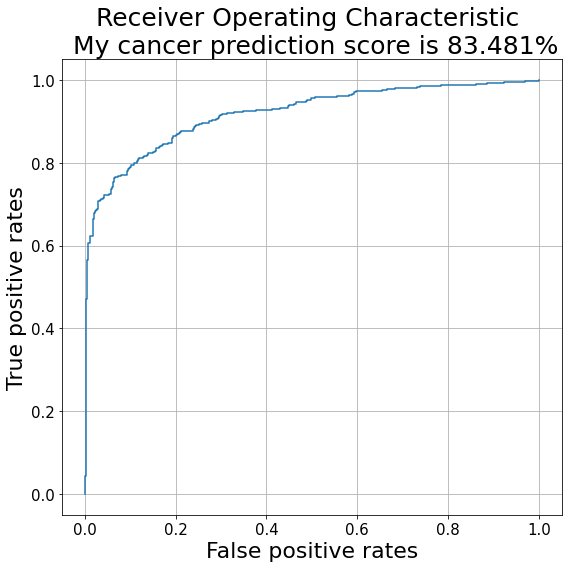

In [352]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(fpr,tpr)

ax.set_title("Receiver Operating Characteristic \n My cancer prediction score is {0:.3f}%".format(LogResPred.score(X_test_2, Y_test_2)*100), fontsize=25)
ax.set_xlabel("False positive rates", fontsize=22)
ax.set_ylabel("True positive rates", fontsize=22)
ax.grid()
ax.tick_params(axis="both", labelsize=15)

fig.tight_layout()

plt.show()

In [353]:
cancerSeeker_outcome[cancerSeeker_outcome.columns[1]] = pd.to_numeric(cancerSeeker_outcome[cancerSeeker_outcome.columns[1]].replace(['Positive', 'Negative'], ['1', '0']))
cancerSeeker_outcome

CancerSEEK Logistic Regression Score  CancerSEEK Test Result
0                                 0.938342                       1
1                                 0.925363                       1
2                                 0.852367                       0
3                                 0.617639                       0
4                                 0.318434                       0
...                                    ...                     ...
1812                              0.980312                       1
1813                              0.999995                       1
1814                              1.000000                       1
1815                              1.000000                       1
1816                              1.000000                       1

[1803 rows x 2 columns]

In [354]:
def accurace_score(arr1, arr2):
    """
    INPUT:
        2 arrays to compare
    OUTPUT:
        Percentage of similarity by counting equal values
    NOTE:
        1. Doesn't check for same lenght
        2. Doesn't check for non-zero lenght
    """
    return sum(np.equal(arr1,arr2))/len(arr1)

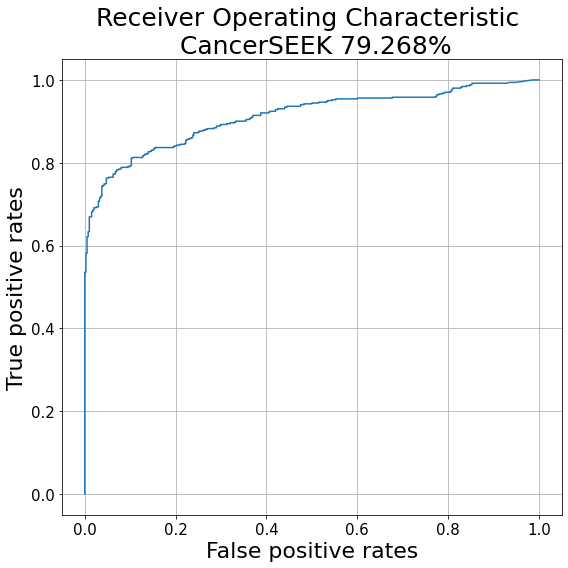

In [355]:
fpr_2, tpr_2, thresholds = roc_curve(Y_test_2, cancerSeeker_outcome[cancerSeeker_outcome.columns[0]][0::2])

fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(fpr_2,tpr_2)

ax.set_title("Receiver Operating Characteristic \n CancerSEEK {0:.3f}%".format(accurace_score(np.array(Y_test_2),np.array(cancerSeeker_outcome[cancerSeeker_outcome.columns[1]][0::2]))*100), fontsize=25)
ax.set_xlabel("False positive rates", fontsize=22)
ax.set_ylabel("True positive rates", fontsize=22)
ax.grid()
ax.tick_params(axis="both", labelsize=15)

fig.tight_layout()

plt.show()

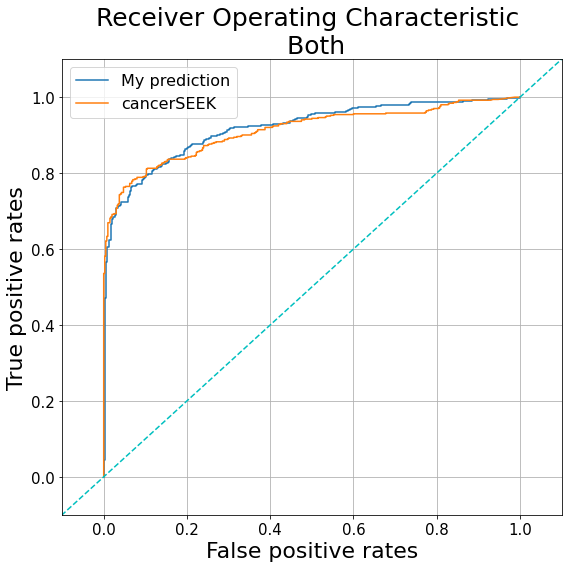

In [356]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(fpr,tpr, label="My prediction")
ax.plot(fpr_2,tpr_2, label="cancerSEEK")
ax.plot(np.linspace(-1.1,1.1,100),np.linspace(-1.1,1.1,100),"--c")

ax.set_title("Receiver Operating Characteristic \n Both".format(accurace_score(np.array(Y_test_2),np.array(cancerSeeker_outcome[cancerSeeker_outcome.columns[1]][0::2]))*100), fontsize=25)
ax.set_xlabel("False positive rates", fontsize=22)
ax.set_ylabel("True positive rates", fontsize=22)
ax.grid()
ax.tick_params(axis="both", labelsize=15)

ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)

ax.legend(loc="best", fontsize=16)

fig.tight_layout()

plt.show()

### Confusion matric

In [357]:
C_MY = metrics.confusion_matrix(Y_test_2, Y_pred_2)
C_CK = metrics.confusion_matrix(Y_test_2, np.array(cancerSeeker_outcome[cancerSeeker_outcome.columns[1]][0::2]))

display(C_MY)
display(C_CK)

array([[338,  62],
       [ 87, 415]], dtype=int64)

array([[397,   3],
       [184, 318]], dtype=int64)

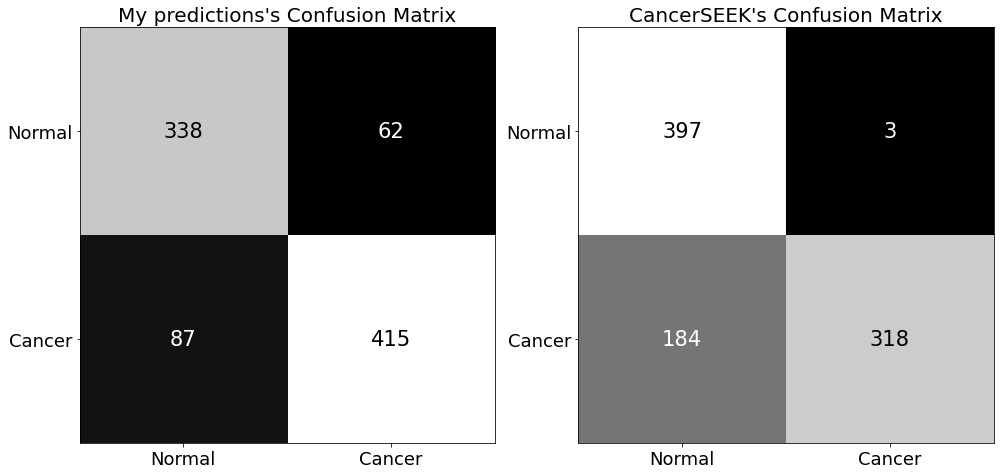

In [358]:
fig,ax = plt.subplots(1,2,figsize=(14,7))

for i in range(2):
    ax[i].set_xticks(np.arange(0,len(C_MY[0,:])))            #class ticks place
    ax[i].set_yticks(np.arange(0,len(C_MY[:,0])))            #survived ticks place
    ax_x = ["Normal", "Cancer"]                           #class tick labels
    ax_y = ["Normal", "Cancer"]                           #survived tick labels
    ax[i].set_xticklabels(ax_x, fontsize=18)
    ax[i].set_yticklabels(ax_y, fontsize=18)

    
ax[0].set_title("My predictions's Confusion Matrix", fontsize=20)
ax[1].set_title("CancerSEEK's Confusion Matrix", fontsize=20)
ax[0].imshow(C_MY, cmap="gray")
ax[1].imshow(C_CK, cmap="gray")

for i in range(0,len(C_MY)):
    for j in range(0,2):
        color0="black"
        if(int(round(C_MY[i,j])) < int(round(np.max(C_MY)))*0.7):
            color0 = "white"
        text = ax[0].text(j, i, str(C_MY[i, j]),
                       ha="center", va="center", color=color0, fontsize=21)    
        
for i in range(0,len(C_CK)):
    for j in range(0,2):
        color0="black"
        if(int(round(C_CK[i,j])) < int(round(np.max(C_CK)))*0.7):
            color0 = "white"
        text = ax[1].text(j, i, str(C_CK[i, j]),
                       ha="center", va="center", color=color0, fontsize=21)    

fig.tight_layout()

plt.show()

So, my prediction said that someone is normal rather then cancerous compared to cancerSEEK, which called normal people cancerous, while accurately predicting normal people.

`CONCLUSION`: cancerSEEK is missing a lot of cancerous people in the process, which is not safe. It may be more wasteful but safer if we call more people cancerous, rather then missing a lot.

### 4. Hepatocellular carcinoma

* fit a logistic regression (using statsmodels API this time) to predict if a sample has Hepatocellular carcinoma (liver cancer) or not. You need to keep only the liver and the normal samples for this exercise! For fitting use only the first 25 features and all the rows (which are liver or normal)
* select the 5 best predictor based on P values.
* Write down the most important features (based on P value) and compare them to the tumor markers that you find on wikipeida https://en.wikipedia.org/wiki/Hepatocellular_carcinoma or other sources!



In [371]:
import statsmodels.api as sm

In [359]:
#ar0 = np.array([1,2,3,4,5,3,2,1])*10
#m1 = ar0 == 30
#m2 = ar0 == 20
#ar0[m1+m2]

In [366]:
m1 = tumor_type == 'Liver'
m2 = tumor_type == 'Normal'

t_coded = tumor_type[m1 + m2].replace(['Liver', 'Normal'], ['1', '0'])
t_coded

145     1
146     1
147     1
148     1
188     1
       ..
1698    0
1699    0
1700    0
1701    0
1702    0
Name: Tumor type, Length: 843, dtype: object

Liver is for cancer, so it stays 1. Otherwise its normal which is 0 with my conventions! Now, let's slice!

In [412]:
#lets separate stuff
X_2_ = data0[data0.columns[4:(25+4)]][m1+m2]   #X
Y_2_ = pd.to_numeric(t_coded)                  #target Y
 
display(X_2_.info())

#X_2_ = np.array(X_2_)
#Y_2_ = np.array(Y_2_)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 843 entries, 145 to 1702
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AFP (pg/ml)              843 non-null    float64
 1   Angiopoietin-2 (pg/ml)   843 non-null    float64
 2   AXL (pg/ml)              843 non-null    float64
 3   CA-125 (U/ml)            843 non-null    float64
 4   CA 15-3 (U/ml)           843 non-null    float64
 5   CA19-9 (U/ml)            843 non-null    float64
 6   CD44 (ng/ml)             843 non-null    float64
 7   CEA (pg/ml)              843 non-null    float64
 8   CYFRA 21-1 (pg/ml)       843 non-null    float64
 9   DKK1 (ng/ml)             843 non-null    float64
 10  Endoglin (pg/ml)         843 non-null    float64
 11  FGF2 (pg/ml)             843 non-null    float64
 12  Follistatin (pg/ml)      843 non-null    float64
 13  Galectin-3 (ng/ml)       843 non-null    float64
 14  G-CSF (pg/ml)          

None

In [413]:
#fitting with statsmodel.api LOGIT

log_reg = sm.Logit(Y_2_, X_2_).fit()

Optimization terminated successfully.
         Current function value: 0.030829
         Iterations 12


In [414]:
display(log_reg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Tumor type   No. Observations:                  843
Model:                          Logit   Df Residuals:                      818
Method:                           MLE   Df Model:                           24
Date:                Thu, 14 Oct 2021   Pseudo R-squ.:                  0.8496
Time:                        22:27:59   Log-Likelihood:                -25.989
converged:                       True   LL-Null:                       -172.75
Covariance Type:            nonrobust   LLR p-value:                 3.359e-48
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
AFP (pg/ml)              3.085e-05   1.12e-05      2.750      0.006    8.86e-06    5.28e-05
Angiopoietin-2 (pg/ml)     -0.0003      0.000     -1.108      0.268      -0.001       0.000
AXL (pg/ml)                 0.0005      0.001      0.968      0.333      -0.001       0.002
CA-125 (U/ml)               0.4014      0.177      2.266      0.023       0.054       0.749
CA 15-3 (U/ml)              0.0593      0.036      1.631      0.103      -0.012       0.131
CA19-9 (U/ml)               0.0014      0.006      0.234      0.815      -0.010       0.013
CD44 (ng/ml)               -0.3546      0.135     -2.629      0.009      -0.619      -0.090
CEA (pg/ml)                -0.0007      0.001     -1.132      0.258      -0.002       0.001
CYFRA 21-1 (pg/ml)          0.0002      0.001      0.287      0.774      -0.001       0.002
DKK1 (ng/ml)               -8.5272      2.608     -3.269      0.001     -13.639      -3.415
Endoglin (pg/ml)            0.0002      0.000      0.595      0.552      -0.001       0.001
FGF2 (pg/ml)                0.0065      0.011      0.612      0.540      -0.014       0.027
Follistatin (pg/ml)         0.0012      0.001      1.240      0.215      -0.001       0.003
Galectin-3 (ng/ml)         -0.0472      0.179     -0.263      0.792      -0.399       0.304
G-CSF (pg/ml)              -0.0013      0.003     -0.388      0.698      -0.008       0.005
GDF15 (ng/ml)               1.0730      0.684      1.569      0.117      -0.267       2.413
HE4 (pg/ml)                -0.0014      0.000     -3.276      0.001      -0.002      -0.001
HGF (pg/ml)                 0.0265      0.007      3.594      0.000       0.012       0.041
IL-6 (pg/ml)                0.0224      0.057      0.395      0.693      -0.089       0.133
IL-8 (pg/ml)                0.0134      0.013      1.069      0.285      -0.011       0.038
Kallikrein-6 (pg/ml)     4.944e-05      0.000      0.267      0.790      -0.000       0.000
Leptin (pg/ml)          -3.453e-05   2.32e-05     -1.491      0.136   -7.99e-05    1.09e-05
Mesothelin (ng/ml)          0.0772      0.052      1.486      0.137      -0.025       0.179
Midkine (pg/ml)            -0.0014      0.001     -1.233      0.218      -0.004       0.001
Myeloperoxidase (ng/ml)     0.0309      0.014      2.143      0.032       0.003       0.059
===========================================================================================

Possibly complete quasi-separation: A fraction 0.48 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [409]:
highest_p = np.sort(log_reg.pvalues)[::-1][0:5]
display(highest_p)
locs = data0[data0.columns[4:(25+4)]][m1+m2].columns == "nyani"
for i in range(5):
    mask = highest_p[i] == log_reg.pvalues 
    locs = locs + mask
for i in range(5):
    print(data0[data0.columns[4:(25+4)]][m1+m2].columns[locs][i])

array([0.81502441, 0.79226463, 0.78983935, 0.77411273, 0.69771376])

CA19-9 (U/ml)
CYFRA 21-1 (pg/ml)
Galectin-3 (ng/ml)
G-CSF (pg/ml)
Kallikrein-6 (pg/ml)


These are the mos impactful predictors. Let's check if they align with the experiments results!

`CHECKS SITE`

It seems like AFP should be in the 5 ostimpactful feature. Maybe scaling data solves it?

In [415]:
from sklearn.preprocessing import StandardScaler

def norm_data(x):
    #I DONT LIKE BURNING
    x = pd.DataFrame(StandardScaler().fit_transform(x), index=x.index, columns=x.columns)
    return x

In [418]:
X_2_ = norm_data(data0[data0.columns[4:(25+4)]][m1+m2])   #normed X
Y_2_ = pd.to_numeric(t_coded)                             #target Y

log_reg = sm.Logit(Y_2_, X_2_).fit()

display(log_reg.summary())

highest_p = np.sort(log_reg.pvalues)[::-1][0:5]
display(highest_p)
locs = data0[data0.columns[4:(25+4)]][m1+m2].columns == "nyani"
for i in range(5):
    mask = highest_p[i] == log_reg.pvalues 
    locs = locs + mask
for i in range(5):
    print(data0[data0.columns[4:(25+4)]][m1+m2].columns[locs][i])

Optimization terminated successfully.
         Current function value: 0.090309
         Iterations 12


E:\ANACONDA\conda\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Tumor type   No. Observations:                  843
Model:                          Logit   Df Residuals:                      818
Method:                           MLE   Df Model:                           24
Date:                Thu, 14 Oct 2021   Pseudo R-squ.:                  0.5593
Time:                        22:34:45   Log-Likelihood:                -76.130
converged:                       True   LL-Null:                       -172.75
Covariance Type:            nonrobust   LLR p-value:                 2.107e-28
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
AFP (pg/ml)                28.3858      3.074      9.234      0.000      22.361      34.411
Angiopoietin-2 (pg/ml)     -1.4211      0.479     -2.964      0.003      -2.361      -0.481
AXL (pg/ml)                 0.2534      0.261      0.971      0.332      -0.258       0.765
CA-125 (U/ml)              12.7752      3.056      4.181      0.000       6.786      18.764
CA 15-3 (U/ml)             -0.0639      0.253     -0.253      0.800      -0.560       0.432
CA19-9 (U/ml)              10.5030      3.869      2.715      0.007       2.921      18.085
CD44 (ng/ml)               -1.3241      0.505     -2.620      0.009      -2.315      -0.333
CEA (pg/ml)                 1.3520      2.074      0.652      0.514      -2.713       5.417
CYFRA 21-1 (pg/ml)          0.1376      0.258      0.533      0.594      -0.368       0.643
DKK1 (ng/ml)               -0.7320      0.322     -2.272      0.023      -1.364      -0.100
Endoglin (pg/ml)            0.1150      0.207      0.557      0.578      -0.290       0.520
FGF2 (pg/ml)               -0.4488      0.323     -1.391      0.164      -1.081       0.183
Follistatin (pg/ml)         0.4130      0.302      1.366      0.172      -0.180       1.006
Galectin-3 (ng/ml)          0.4587      0.378      1.213      0.225      -0.283       1.200
G-CSF (pg/ml)               0.0613      0.307      0.200      0.842      -0.540       0.662
GDF15 (ng/ml)              -2.6299      0.715     -3.678      0.000      -4.031      -1.229
HE4 (pg/ml)                -0.6244      0.539     -1.158      0.247      -1.681       0.432
HGF (pg/ml)                 4.8418      0.984      4.918      0.000       2.912       6.771
IL-6 (pg/ml)                0.4312      0.309      1.394      0.163      -0.175       1.037
IL-8 (pg/ml)                0.4337      0.240      1.805      0.071      -0.037       0.905
Kallikrein-6 (pg/ml)       -0.2725      0.255     -1.069      0.285      -0.772       0.227
Leptin (pg/ml)             -0.1208      0.299     -0.403      0.687      -0.708       0.466
Mesothelin (ng/ml)          0.6862      0.328      2.095      0.036       0.044       1.328
Midkine (pg/ml)            -0.1290      0.240     -0.538      0.591      -0.599       0.341
Myeloperoxidase (ng/ml)     0.5600      0.343      1.633      0.102      -0.112       1.232
===========================================================================================

Possibly complete quasi-separation: A fraction 0.11 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

array([0.84161411, 0.80047858, 0.68659262, 0.59395162, 0.59079386])

CA 15-3 (U/ml)
CYFRA 21-1 (pg/ml)
G-CSF (pg/ml)
Leptin (pg/ml)
Midkine (pg/ml)


E:\ANACONDA\conda\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(
E:\ANACONDA\conda\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(
E:\ANACONDA\conda\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(
E:\ANACONDA\conda\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(
E:\ANACONDA\conda\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: eva

Now they seem to be better as Leptin is connected to type-2 diabetes, which can be a common metabollic risk factor. Midkine is a great hit too as it seem to be connected to the development of the tumor. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5464806/

On the other hand, G-CSF seems to be not conencted at all. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6498295/]

And all others seem to b connected to a different type of cancer...

### 5. Multiclass classification

* Again, using every second datapoint train a logistic regression (sklearn API) to predict the tumor type. It is a multiclass classification problem.
* Generate prediction for the rest of the dataset and show the confution matrix for the predictions!
* Plot the ROC curves for the different cancer types on the same plot!
* Intepret your results. Which cancer type can be predicted the most reliably?



In [425]:
#tumor type
display(tumor_type.value_counts())
t_type_2 = tumor_type.replace(['Normal','Colorectum','Breast','Lung', 'Pancreas', 'Stomach', 'Ovary', 'Esophagus', 'Liver'], 
                                ['0','1','2','3','4','5','6','7','8'])
display(t_type_2.value_counts())

Normal        799
Colorectum    388
Breast        208
Lung          104
Pancreas       93
Stomach        68
Ovary          54
Esophagus      45
Liver          44
Name: Tumor type, dtype: int64

0    799
1    388
2    208
3    104
4     93
5     68
6     54
7     45
8     44
Name: Tumor type, dtype: int64

In [430]:
#lets separate stuff
X_ = data0[data0.columns[4:]]    #X
Y_ = t_type_2     #target Y

X_train_2 = X_[1::2]
X_test_2 = X_[::2]

Y_train_2 = Y_[1::2]
Y_test_2 = Y_[::2]

#‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
LogResPred = LogisticRegression(max_iter=10000000,solver='saga').fit(X_train_2,Y_train_2)
Y_pred_2 = LogResPred.predict(X_test_2)

### Hints:

* On total you can get 10 points for fully completing all tasks.
* Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
* Comments you code when necessary
* Write functions for repetitive tasks!
* Use the pandas package for data loading and handling
* Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
* Use the scikit learn package for almost everything
* Use for loops only if it is really necessary!
* Code sharing is not allowed between student! Sharing code will result in zero points.
* If you use code found on web, it is OK, but, make its source clear!